Initial dataset sizes: SimLex = 100, Singlish = 63
After eliminating missing words: SimLex = 85, Singlish = 31
Spearman cor(SgE, AmE) on SimLex: 0.57 (p = 1.23e-08), on Singlish: 0.51 (p = 0.00365)


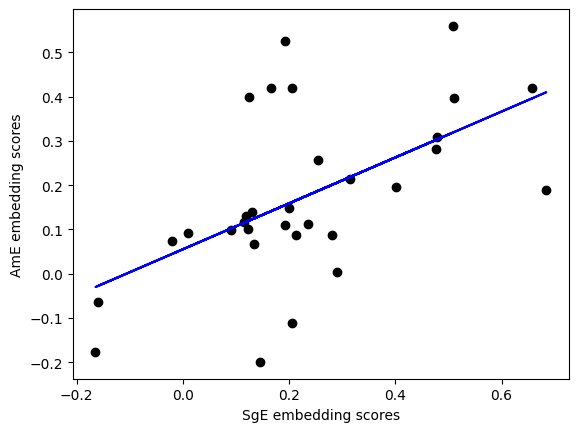

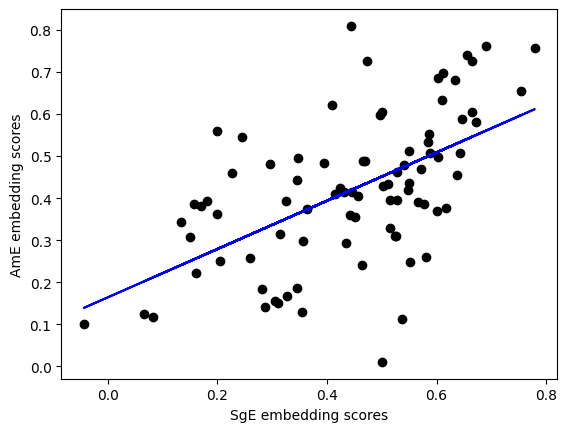

z_obs 0.4101874879628188
Critical value for alpha = 0.05 is approximately 1.959963984540054
Since z_obs < z_crit, there is not enough evidence to conclude that there is a difference in correlation between the SgE and AmE embeddings for the two datasets.


In [21]:
import csv
from gensim.models import Word2Vec

sgtb_emb = Word2Vec.load('../embeddings/sgtb_word2vec_no_lemmatize.embedding')
coca_emb = Word2Vec.load('../embeddings/coca_word2vec_no_lemmatize.embedding')

# lists of word pairs
simLexPairsFull = []

simLexPairs = [
    ['formal','proper'], ['huge','dumb'], ['composer','writer'],
    ['carry','bring'], ['breathe','choke'], ['create','build'],
    ['situation','condition'], ['hard','simple'], ['absence','presence'],
    
    ['couple','pair'], ['aggression','hostility'], ['navy','army'],
    ['abundance','plenty'], ['old','new'], ['army','squad'],
    ['contemplate','think'], ['recent','new'], ['say','participate'],
    
    ['hard','difficult'], ['reality','illusion'], ['bring','restore'],
    ['inexpensive','cheap'], ['chemistry','theory'], ['sly','strange'],
    ['day','morning'], ['endurance','band'], ['word','dictionary'],
    
    ['unhappy','mad'], ['large','big'], ['kill','choke'],
    ['chicken','steak'], ['apple','sunshine'], ['danger','disease'],
    ['go','sell'], ['communicate','pray'], ['cab','bus'],
    
    ['nice','generous'], ['greet','meet'], ['dirty','narrow'],
    ['container','mouse'], ['leg','arm'], ['bean','coffee'],
    ['comfort','safety'], ['milk','juice'], ['friend','buddy'],
    
    ['creator','maker'], ['science','psychology'], ['dumb','intelligent'],
    ['corporation','business'], ['great','awful'], ['weird','normal'],
    ['sharp','dull'], ['overcome','dominate'], ['book','text'],
    
    ['modest','flexible'], ['mouth','tooth'], ['joy','pride'],
    ['easy','difficult'], ['leader','manager'], ['rhythm','melody'],
    ['receive','give'], ['marijuana','herb'], ['absorb','possess'],
    
    ['short','long'], ['simple','easy'], ['rat','mouse'],
    ['think','decide'], ['dollar','people'], ['friend','guest'],
    ['accept','believe'], ['game','fun'], ['boundary','border'],
    
    ['tobacco','cigarette'], ['street','alley'], ['belief','impression'],
    ['crowd','bunch'], ['kill','hang'], ['victory','triumph'],
    ['cloud','storm'], ['lawyer','banker'], ['old','fresh'],

    ['god','spirit'], ['guilty','ashamed'], ['explain','prove'],
    ['listen','hear'], ['make','earn'], ['accept','acknowledge'],
    ['big','heavy'], ['violent','angry'], ['come','bring'],

    ['forget','learn'], ['achieve','accomplish'], ['winter','season'],
    ['happy','young'], ['attention','awareness'], ['woman','wife'],
    ['protect','defend'], ['inform','notify'], ['cherish','keep'],
    ['leave','enter']
]

singlishPairs = [
    ['can','okay'], ['blur','ignorant'],
    ['pattern','behavior'], ['mug','study'],
    ['chop','reserve'], ['hawker','peddler'],
    ['rubber','eraser'], ['biscuit','cookie'],
    ['vest','singlet'], ['keep','always'],
    ['letter','character'], ['lift','elevator'],
    ['bill','cheque'], ['chips','fries'],
    ['trolley','cart'], ['dummy','mannequin'],
    ['flat','apartment'], ['boot','expel'],
    ['rocket','vegetable'], ['takeaway','pack'],
    ['football','rugby']
]

singlishPairsWikipedia = [
    ['basket','bastard'], ['chop','reserve'], ['damn','very'],
    ['diam','quiet'], ['get','cheeky'], ['handphone','mobile'],
    ['mug','study'], ['orbit','old-fashioned'], ['photostat','photocopy'],
    ['pon','truant'], ['sod','mental'], ['solid','good'],
    ['song','nice'], ['toot','stupid'], ['un','understand'],
    ['arrow','delegate'], ['auntie','adult'], ['banana','western'],
    ['blur','clueless'], ['can','okay'], ['confirm','sure'],
    ['earpiece','headphone'], ['follow','understand'], ['got','have'],
    ['jam','congestion'], ['lightbulb','third-wheel'], ['never','yet'],
    ['one','de'], ['on','settled'], ['open','on'],
    ['power','good'], ['revert','reply'], ['send','drive'],
    ['solid','excellent'], ['steady','excellent'], ['spoil','broken'],
    ['stay','live'], ['step','act'], ['steady','attached'],
    ['steady','agree'], ['steady','capable'], ['stone','daydream'],
    ['take','eat'], ['uncle','adult'], ['until','extent']
]

def compareScores(pairs, num_to_show = None, print_missing_keys = False):
    scores = []
    for pair in pairs:
        sgtb_score = getSgEScore(pair[0], pair[1], print_missing_keys)
        coca_score = getAmEScore(pair[0], pair[1], print_missing_keys)
        if sgtb_score != None and coca_score != None:
            scores.append({
                "pair": pair, "diff": sgtb_score - coca_score,
                "sgtb": sgtb_score, "coca": coca_score
            })
    scores.sort(key=lambda x: x["diff"], reverse=True)

    if print_missing_keys: print('-' * 20)
    if num_to_show and num_to_show * 2 < len(scores):
        for x in scores[:num_to_show]: print(x)
        for x in scores[-num_to_show:]: print(x)
    else:
        for x in scores: print(x)

def getSgEScore(word1, word2, print_missing_keys = False):
    try:
        return sgtb_emb.wv.similarity(word1, word2)
    except Exception as e:
        if print_missing_keys:
            print('sgtb missing key:', e)
        return None

def getAmEScore(word1, word2, print_missing_keys = False):
    try:
        return coca_emb.wv.similarity(word1, word2)
    except Exception as e:
        if print_missing_keys:
            print('coca missing key:', e)
        return None

def statisticalTest():
    import matplotlib.pyplot as plt
    import scipy as sp
    import numpy as np
    import random
    import math
    from sklearn import linear_model

    enableSimLexSampling = False
    enableFisherTransform = True

    singlishPairsAll = set(tuple(x) for x in singlishPairs + singlishPairsWikipedia)
    print(f"Initial dataset sizes: SimLex = {len(simLexPairs)}, Singlish = {len(singlishPairsAll)}")

    # Spearman correlation between SgE & AmE for Singlish pairs
    singlishScores = [[getSgEScore(p[0], p[1]) for p in singlishPairsAll],
                      [getAmEScore(p[0], p[1]) for p in singlishPairsAll]]
    for i in range(len(singlishScores[0]) - 1, -1, -1):
        if singlishScores[0][i] == None or singlishScores[1][i] == None:
            singlishScores[0].pop(i)
            singlishScores[1].pop(i)
    r2, p2 = sp.stats.spearmanr(np.array(singlishScores).T)

    # Spearman correlation between SgE & AmE for SimLex pairs
    simLexScores = [[getSgEScore(p[0], p[1]) for p in simLexPairs],
                    [getAmEScore(p[0], p[1]) for p in simLexPairs]]
    for i in range(len(simLexScores[0]) - 1, -1, -1):
        if simLexScores[0][i] == None or simLexScores[1][i] == None:
            simLexScores[0].pop(i)
            simLexScores[1].pop(i)
    if enableSimLexSampling: # randomly sample from simlex set for computing spearman's r
        score, times = 0, 0
        while times < 100:
            simLexSample = []
            indices = list(range(len(simLexScores[0])))
            indices = sorted(random.sample(indices, len(singlishScores[0])), reverse=True)
            for i in indices:
                simLexSample.append([simLexScores[0][i], simLexScores[1][i]])
            r, p = sp.stats.spearmanr(np.array(simLexSample))
            if p < 0.05:
                score += r
                times += 1
        r = score / times
    else:
        r, p = sp.stats.spearmanr(np.array(simLexScores).T)
    print(f"After eliminating missing words: SimLex = {len(simLexScores[0])}, Singlish = {len(singlishScores[0])}")
    print("Spearman cor(SgE, AmE) on SimLex: %.2g (p = %.3g), on Singlish: %.2g (p = %.3g)" % (r, p, r2, p2))

    # plots
    c, d = np.polyfit(singlishScores[0], singlishScores[1], 1)
    plt.scatter(singlishScores[0], singlishScores[1], color="black")
    plt.plot(singlishScores[0], c * np.array(singlishScores[0]) + d, color="blue")
    plt.xlabel('SgE embedding scores')
    plt.ylabel('AmE embedding scores')
    plt.show()

    c, d = np.polyfit(simLexScores[0], simLexScores[1], 1)
    plt.scatter(simLexScores[0], simLexScores[1], color="black")
    plt.plot(simLexScores[0], c * np.array(simLexScores[0]) + d, color="blue")
    plt.xlabel('SgE embedding scores')
    plt.ylabel('AmE embedding scores')
    plt.show()

    if enableFisherTransform: # Fisher's r to z transform
        z = np.arctanh([r, r2])
        z_obs = (z[0] - z[1]) / math.sqrt(1 / (len(simLexScores[0]) - 3) + 1 / (len(singlishScores[0]) - 3)) # formula taken from: https://www.statisticssolutions.com/comparing-correlation-coefficients/
        print("z_obs", z_obs) # approximately similar to result in http://vassarstats.net/rdiff.html
        
        alpha = 0.05
        z_crit = sp.stats.norm.ppf(1 - alpha / 2)
        print("Critical value for alpha =", alpha, "is approximately", z_crit)
        print("Since z_obs < z_crit, there is not enough evidence to conclude that there is a difference in correlation between the SgE and AmE embeddings for the two datasets.")


if __name__ == '__main__':
    with open('../raw_data/SimLex-999.txt', 'r') as f:
        csv_reader = csv.reader(f, delimiter="\t")
        titles = next(csv_reader)
        for i, row in enumerate(csv_reader):
            simLexPairsFull.append([row[0], row[1]])

    statisticalTest()
    # compareScores(simLexPairsFull, 5)
    # compareScores(simLexPairs, 5)
    # compareScores(singlishPairs, 5)
    # compareScores(singlishPairsWikipedia, 5)

# interesting observations:
# 1. some word pairs are unexpectedly assigned greater scores by coca_emb than sgtb_emb
